# Демонстрация работы Non-maximum Suppression (NMS) с помощью KMeans

Оставляем все предсказанные bbox модели Yolo (нет фильтра по уверенности, не применяется встроенный NMS)

Разбиваем все bbox на кластеры (кол-во кластеров зависит от максимального кол-ва bbox, которые мы хотим получить на одной картинке)

После к полученным кластерам применяем NMS алгоритм

Данный подход использован для того, чтобы учитывать объекты с низким confidence и делать nms вне зависимости от класса объекта

In [1]:
import sys

sys.path
sys.path.append("../yolov5")

In [2]:
from assh_utils import nms
from yolo_utils import CustomWrapper, DetectMultiBackend

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline

In [4]:
model = CustomWrapper(DetectMultiBackend("./yolov5n.pt"))
img = "./children.jpg"
x = model([img])
df = x.pandas().xyxy[0]

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


In [5]:
kmeans = KMeans(n_clusters=30, random_state=0).fit(df[["xmin", "ymin", "xmax", "ymax"]])
df["labels"] = kmeans.labels_

### Визуализация всех исходных кропов модели с разбиением по кластерам (каждый кластер выделен своим цветом)

In [6]:
image = cv2.imread(img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
for label in df["labels"].unique():
    match = df[df["labels"] == label][["xmin", "ymin", "xmax", "ymax"]].astype(np.int32)
    c = (
        np.random.rand(
            3,
        )
        * 255
    )
    for _, m in match.iterrows():
        overlay = cv2.rectangle(image, (m["xmin"], m["ymin"]), (m["xmax"], m["ymax"]), c, 1)
        image = cv2.addWeighted(overlay, 0.1, image, 0.9, 0)

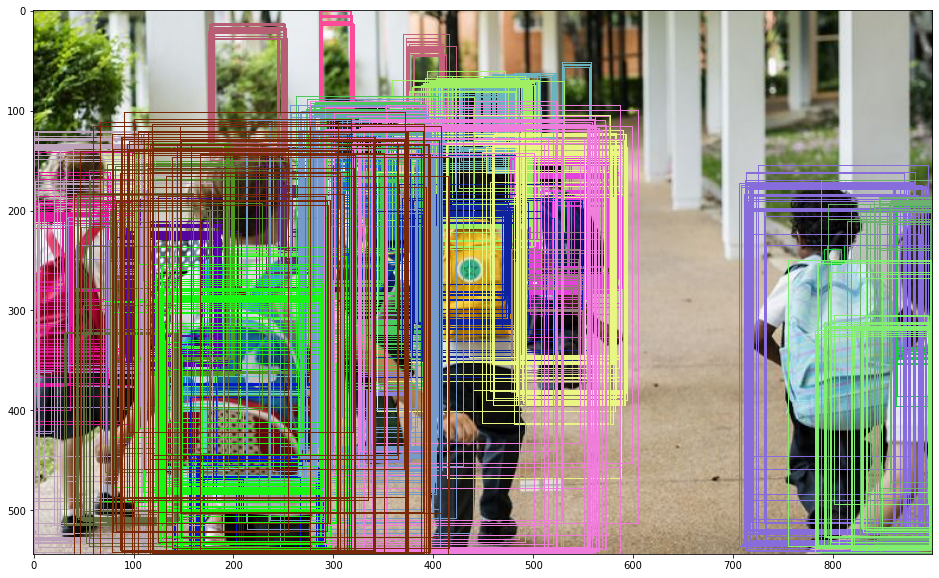

In [8]:
plt.figure(figsize=(18, 10))
plt.imshow(image)
plt.show()

### Визуализация KMeans + NMS bbox

In [9]:
image = cv2.imread(img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
for label in df["labels"].unique():
    #     match = df.iloc[df[df['labels'] == label]['confidence'].idxmax()][['xmin', 'ymin', 'xmax', 'ymax']].astype(np.int32)
    match = df[df["labels"] == label]
    keep = nms(match[["xmin", "ymin", "xmax", "ymax"]].values, match["confidence"].values, 0.45, max_dets=10)
    for k in keep:
        m = match.iloc[k][["xmin", "ymin", "xmax", "ymax"]].astype(np.int32)
        image = cv2.rectangle(
            image,
            (m["xmin"], m["ymin"]),
            (m["xmax"], m["ymax"]),
            np.random.rand(
                3,
            )
            * 255,
            2,
        )

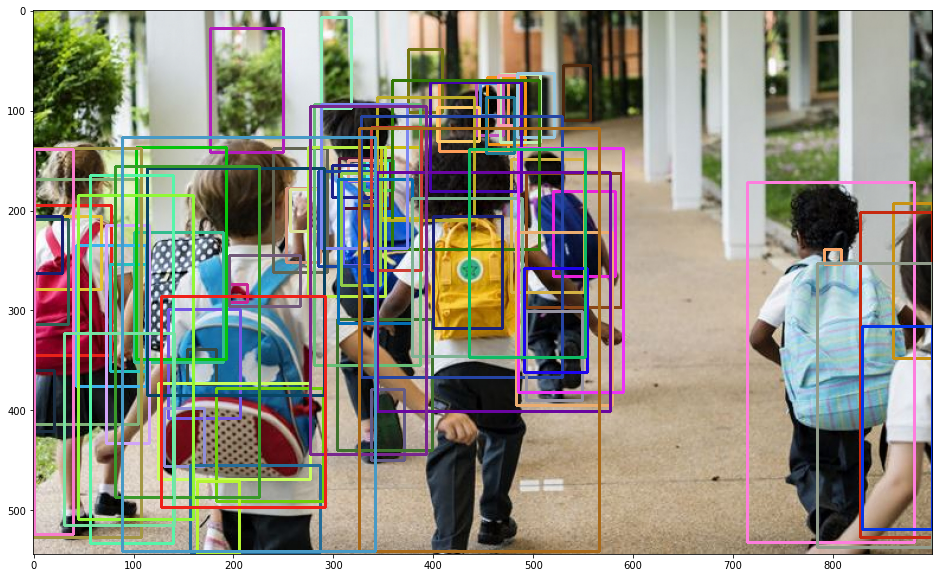

In [11]:
plt.figure(figsize=(18, 10))
plt.imshow(image)
plt.show()